<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Dataset processing
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      CHIA
  </div>
  
  
<div style="
      font-weight: normal; 
      font-size: 15px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Jean-baptiste AUJOGUE
  </div>


<a id="TOC"></a>

#### Table Of Content

1. [CHIA Texts](#texts) <br>
2. [CHIA Entities](#ents) <br>


#### Useful links

- [CHIA a large annotated corpus of clinical trial eligibility criteria](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7452886/pdf/41597_2020_Article_620.pdf) (paper)
- https://github.com/uf-hobi-informatics-lab/ClinicalTransformerNER/blob/master/tutorial/brat2bio.ipynb
- https://github.com/ctgatecci/Clinical-trial-eligibility-criteria-NER/blob/main/NER%20Preprocessing%20and%20Performance%20Analysis.ipynb

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import os
import sys
import re
import copy
import json
import zipfile

# data
import pandas as pd

# text
from spacy.lang.en import English

#### Custom variables

In [71]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets', 'chia')
path_to_src  = os.path.join(path_to_repo, 'src')
path_to_src

'C:\\Users\\jb\\Desktop\\NLP\\perso - Transformers for NLP\\src'

In [72]:
base_dataset_name  = 'chia.zip'
final_dataset_name = 'chia-ner'

#### Custom imports

In [73]:
sys.path.insert(0, path_to_src)

In [74]:
from nlptools.dataset.chia.io import load_texts_from_zipfile, load_entities_from_zipfile, dicts_to_jsonl
from nlptools.dataset.chia.preprocessing import get_ner_entities, convert_to_bio, convert_to_prompts

<a id="texts"></a>

# 1. CHIA Texts

[Table of content](#TOC)

In [75]:
folder = os.path.join(path_to_data, final_dataset_name)
if not os.path.isdir(folder):
    os.makedirs(folder)

In [76]:
df_texts = load_texts_from_zipfile(os.path.join(path_to_data, base_dataset_name))

In [77]:
df_texts.head()

,Id,Text
0,NCT00050349_exc,Patients with symptomatic CNS metastases or le...
1,NCT00050349_inc,Patients with biopsy-proven metastatic carcino...
2,NCT00061308_exc,Women of child-bearing potential that do not p...
3,NCT00061308_inc,Have had one prior platinum-based chemotherapy...
4,NCT00094861_exc,Metastatic disease (M1)/stage 4 NSCLC \nPleura...


In [78]:
df_texts.to_csv(os.path.join(path_to_data, final_dataset_name, 'chia_texts.tsv'), sep = "\t", index = False)

<a id="ents"></a>

# 2. CHIA Entities

[Table of content](#TOC)

## 2.1 Load entities

[Table of content](#TOC)

In [79]:
df_ents = load_entities_from_zipfile(os.path.join(path_to_data, base_dataset_name))
df_ents.shape

(44616, 7)

In [80]:
df_ents.head()

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans
0,NCT00050349_exc,T1,CNS metastases,Condition,26,40,"(26, 40)"
1,NCT00050349_exc,T2,leptomeningeal involvement,Condition,44,70,"(44, 70)"
2,NCT00050349_exc,T5,treated,Procedure,144,151,"(144, 151)"
3,NCT00050349_exc,T6,been stable for,Qualifier,164,179,"(164, 179)"
4,NCT00050349_exc,T7,at least six months prior to study start,Temporal,180,220,"(180, 220)"


In [81]:
df_ents[df_ents.Category == 'Qualifier'].Mention.to_list()

['been stable for',
 'low dose',
 'curatively treated',
 'active',
 'suspected',
 'acute',
 'chronic',
 'symptomatic',
 'bone',
 'stable dose',
 'clinically stable dose',
 'previous',
 'Concomitant',
 'adequately treated',
 'has been disease free',
 'Active uncontrolled',
 'bone',
 'severe',
 'limit full compliance with the study',
 'unrelated to the malignancy',
 'esophagus',
 'invasive',
 'uncontrolled',
 'unresolved',
 'E. coli derived',
 'cytologically proven',
 'histologically proven',
 'Unresectable',
 'locally advanced',
 'esophagus',
 'Initial',
 'study-specific',
 'adequate',
 'Meet DSM-IV criteria',
 'DSM-IV',
 'primary',
 'Comorbid',
 'additional',
 'primary',
 'DSM- IV',
 'concurrent',
 'Stable',
 'uncontrolled',
 'active',
 'active',
 'active',
 'interfere with consent',
 'interfere with follow-up',
 'severe',
 'Unresectable',
 'disease limited to liver',
 'measurable disease',
 'measurable disease',
 'outside the radiation field',
 'responsive to diuretics',
 '20 cc',
 'l

In [82]:
df_ents[df_ents.Char_spans.apply(len) > 2]

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans
19,NCT00050349_exc,T23,greater than 1,Value,751,771,"(751, 763, 770, 771)"
27,NCT00050349_exc,T31,in-dwelling ports,Device,955,981,"(955, 966, 976, 981)"
43,NCT00050349_exc,T53,medical illness,Condition,1311,1341,"(1311, 1318, 1334, 1341)"
47,NCT00050349_exc,T57,inability to return for all scheduled visits,Mood,1443,1504,"(1443, 1452, 1470, 1504)"
77,NCT00050349_inc,T19,major impairment of renal function,Condition,331,376,"(331, 356, 368, 376)"
...,...,...,...,...,...,...,...
44507,NCT03648021_inc,T22,intracranial pressure,Measurement,317,354,"(317, 329, 346, 354)"
44537,NCT03663387_exc,T28,limiting validity of imaging,Qualifier,367,423,"(367, 387, 416, 423)"
44558,NCT03663387_exc,T52,over the counter memory enhancing medications,Drug,792,851,"(792, 825, 840, 851)"
44559,NCT03663387_exc,T53,over the counter memory protecting medications,Drug,792,851,"(792, 815, 829, 851)"


In [83]:
# A sanity check:
check = []
for _id, text in df_texts.values.tolist():
    df_tmp = df_ents[df_ents.Id == _id]
    check_tmp = df_tmp.apply(
        func = lambda r: [_id, r.Mention, text[r.Start_char: r.End_char], r.Char_spans],
        axis = 1,
    ).values.tolist()
    check += check_tmp
    
df_check = pd.DataFrame(check, columns = ['Id', 'Mention', 'Span', 'Char_spans'])

In [84]:
# Mention and Span are the same for *almost* all entities:
print(df_check[df_check.Mention != df_check.Span].shape)
print(df_check[(df_check.Mention != df_check.Span) & (df_check.Char_spans.apply(len) == 2)].shape)

df_check[(df_check.Mention != df_check.Span) & (df_check.Char_spans.apply(len) == 2)]

(1981, 4)
(194, 4)


,Id,Mention,Span,Char_spans
6361,NCT01352598_inc,prostate cancer,prostate cancer,"(383, 399)"
10279,NCT01980680_exc,OHSS development,OHSS development,"(75, 92)"
17492,NCT02425774_exc,chronic pancreatitis,chronic pancreatitis,"(149, 170)"
21757,NCT02590822_inc,Capacity to provide informed consent before an...,Capacity to provide informed consent before an...,"(0, 110)"
23477,NCT02654912_exc,first trimester,first trimester,"(398, 414)"
...,...,...,...,...
39885,NCT03338296_exc,the same,he same,"(6883, 6891)"
39886,NCT03338296_exc,(Note: All female participants will be conside...,Note: All female participants will be consider...,"(7075, 7328)"
40879,NCT03366779_exc,Subject is currently involved in another inves...,Subject is currently involved in another inves...,"(3001, 3065)"
41349,NCT03387059_exc,Known hypersensitivity to any of the component...,Known hypersensitivity to any of the component...,"(820, 884)"


## 2.2 Get flattened non-overlapping entities

[Table of content](#TOC)

In [85]:
categories = [
    # domain
    'Condition',                     # - in C2Q
    'Device',                        # present in OMOP CDM, can be precise ('Pacemaker') or broad ('barrier method of birth control)
    'Drug',                          # - in C2Q
    'Measurement',                   # - in C2Q
    'Person',                        # Demographic (sex, age), but also contains mislabeled Condition ('Premenopausal', drug users'), mislabeled Measurement ('body mass index') and irrelevant terms ('Incarcerated')
    'Procedure',                     # - in C2Q
    'Visit',                         # codable ?
    
    # field
    'Value',                         # - in C2Q
    'Temporal',                      # - in C2Q
    'Qualifier',                     # Originaly a Construct entity. Modifier terms similar to Observation
    'Observation',                   # - in C2Q # greatly overlaps Qualifier, and the delta seems useless
    # 'Reference_point',             # reference point in time, absolute ("3 times the agent's half-life") or relative ('initiation of treatment')
    # 'Mood',                        # useless

    # construct
    # 'Negation',                    # negation expressed as a NER + RelEx problem to be complete
    # 'Multiplier',                  # CAUTION here, as it covers Value ('> 500 mg/m^2') associated with Drug, and and Logical label ('3 or more')
]

In [86]:
df_ents = get_ner_entities(df_texts, df_ents, categories)

In [87]:
df_ents.head()

,Id,Mention,Start_char,End_char,Entity_id,Category
0,NCT00050349_exc,symptomatic,14,25,"(T65,)",Qualifier
1,NCT00050349_exc,CNS metastases,26,40,"(T1,)",Condition
2,NCT00050349_exc,leptomeningeal involvement,44,70,"(T2,)",Condition
3,NCT00050349_exc,brain metastases,92,108,"(T4,)",Condition
4,NCT00050349_exc,treated,144,151,"(T5,)",Procedure


<Axes: >

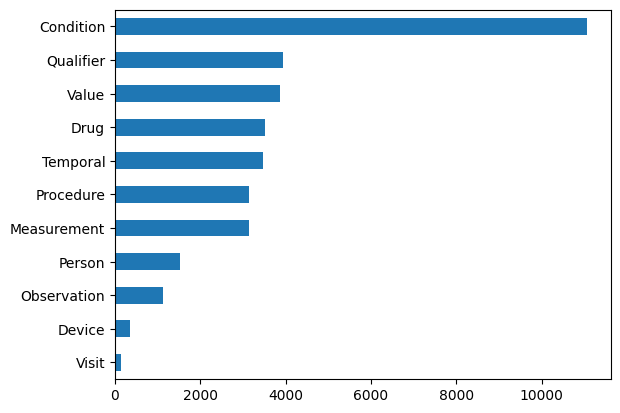

In [88]:
df_ents.Category.value_counts().sort_values().plot(kind = 'barh')

In [89]:
df_ents.to_csv(os.path.join(path_to_data, final_dataset_name, 'chia_ents.tsv'), sep = "\t", index = False)

<a id="bio"></a>

## 2.3 Convert entities to BIO format

[Table of content](#TOC)


In [90]:
df_spans = convert_to_bio(df_texts, df_ents)
df_spans.shape

(76064, 4)

In [91]:
df_spans.head()

,Id,Sequence_id,Mention,Category
0,NCT00050349_exc,NCT00050349_exc_0,Patients with,O
1,NCT00050349_exc,NCT00050349_exc_0,symptomatic,Qualifier
2,NCT00050349_exc,NCT00050349_exc_0,,O
3,NCT00050349_exc,NCT00050349_exc_0,CNS metastases,Condition
4,NCT00050349_exc,NCT00050349_exc_0,or,O


In [92]:
df_spans.to_csv(os.path.join(path_to_data, final_dataset_name, 'chia_spans.tsv'), sep = "\t", index = False)

In [93]:
tokenizer = English()
df_bio = convert_to_bio(df_texts, df_ents, tokenizer = lambda s: [t.text for t in tokenizer(s)])

df_bio.shape

(205290, 4)

In [94]:
df_bio.head(10)

,Id,Sequence_id,Mention,Category
0,NCT00050349_exc,NCT00050349_exc_0,Patients,O
1,NCT00050349_exc,NCT00050349_exc_0,with,O
2,NCT00050349_exc,NCT00050349_exc_0,symptomatic,B-Qualifier
3,NCT00050349_exc,NCT00050349_exc_0,,O
4,NCT00050349_exc,NCT00050349_exc_0,CNS,B-Condition
5,NCT00050349_exc,NCT00050349_exc_0,metastases,I-Condition
6,NCT00050349_exc,NCT00050349_exc_0,,O
7,NCT00050349_exc,NCT00050349_exc_0,or,O
8,NCT00050349_exc,NCT00050349_exc_0,leptomeningeal,B-Condition
9,NCT00050349_exc,NCT00050349_exc_0,involvement,I-Condition


In [95]:
df_bio.to_csv(os.path.join(path_to_data, final_dataset_name, 'chia_bio.tsv'), sep = "\t", index = False)

<a id="prompt"></a>

## 2.3 Convert entities to LLM prompt format

[Table of content](#TOC)


In [96]:
prompts = convert_to_prompts(df_texts, df_ents, bos_term = '', sep_term = '\n\n###\n\n', end_term = '\n\nEND')

In [97]:
prompts[:2]

[{'id': 'NCT00050349_exc_0',
  'prompt': 'Patients with symptomatic CNS metastases or leptomeningeal involvement \n\n###\n\n',
  'completion': 'symptomatic\nQualifier\n\nCNS metastases\nCondition\n\nleptomeningeal involvement\nCondition\n\nEND'},
 {'id': 'NCT00050349_exc_1',
  'prompt': 'Patients with known brain metastases, unless these metastases have been treated and/or have been stable for at least six months prior to study start. Subjects with a history of brain metastases must have a head CT with contrast to document either response or progression. \n\n###\n\n',
  'completion': 'brain metastases\nCondition\n\ntreated\nProcedure\n\nbeen stable for\nQualifier\n\nat least six months prior to study start\nTemporal\n\nhistory of\nTemporal\n\nbrain metastases\nCondition\n\nhead CT with contrast\nProcedure\n\nEND'}]

In [98]:
dicts_to_jsonl(
    data_list = prompts, 
    filename = os.path.join(path_to_data, final_dataset_name, 'chia_prompts.jsonl.gz'), 
    compress = True,
)

[Table of content](#TOC)